# Agglomerative Hierarchial Clustering (AHC)

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.1.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Production"


In the following example, we use AHC to reduce scenarios

$\textbf{Import modules}$

In [1]:
import sys
sys.path.append('../../src')

In [2]:

import pandas 
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.components.result import Result 
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
from energiapy.aggregation.kmeans import kmeans, IncludeKmeans
from energiapy.aggregation.dtw import dynamic_warping, dynamic_warping_matrix, dynamic_warping_path, IncludeDTW
from energiapy.utils.data_utils import load_results
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
from pyearth import Earth
import pyomo.environ as pyo


In [3]:
idx = [(i,j,k) for i,j,k in product(range(1), range(365), range(24))]

In [4]:
def mars_elbow(wcss:list, range_list:list):
    X = [numpy.array([i]) for i in range(len(wcss))]
    mars = Earth()
    mars.fit(X, wcss)
    y_hat = mars.predict(X)
    y_line = y_hat ## for plotting
    #determine the elbow point
    m = numpy.diff(y_line)/numpy.diff(range(len(wcss)))
    m = [numpy.round(i, 2) for i in m]
    m_un = list(set(m))
    elbow = max([m.index(i) + range_list[0] for i in sorted(m_un)])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    x = range_list
    
    ax.plot(x, y_line, label = 'MARS fit', color = 'steelblue', alpha = 0.6)

    ax.scatter(x, wcss, color = 'indianred')
    plt.axvline(x = elbow, alpha = 0.6, linestyle = 'dotted', label = f"elbow at {elbow}", color = 'slategrey', zorder = 3)    

    plt.title(f'Clustering using AHC for Houston for cost and demand')
    plt.xlabel('Cluster Size')
    plt.ylabel('WCSS')
    plt.grid(alpha=0.3)
    plt.legend()
    
    return elbow 


## Data Import

The following data is needed for the model

- solar and wind profiles : energiapy.fetch_nsrdb_data imports data from the NREL NSRDB database
- power demand : ERCOT for Houston; CAISO for San Diego
- Natural Gas prices: Henry Hub Price Index for both


**Get Weather data**

In [5]:
def load_data(loc:str, index:list):
    df = pandas.read_csv(f'../data/{loc}_solar19.csv')
    # df = df[['DNI', 'Wind Speed']]
    # df = df.rename(columns= {'DNI': 'dni', 'Wind Speed': 'wind_speed'})
    df['idx'] = index
    df = df.set_index('idx')
    return df

In [6]:
weather_ny = load_data('ny', idx)[['DNI', 'Wind Speed']]
weather_ny = weather_ny.rename(columns= {'DNI': 'dni', 'Wind Speed': 'wind_speed'})
weather_sd = load_data('sd', idx)[['dni', 'wind_speed']]
weather_ho = load_data('ho', idx)[['dni', 'wind_speed']]


**Demand data for San Diego (CAISO for SDGE region) and Houston (ERCOT for COAST region)**

In [7]:
demand_sd = pandas.read_excel('../data/HistoricalEMSHourlyLoad-2019.xlsx', index_col= 0)[['SDGE']]
demand_ho = pandas.read_excel('../data/Native_Load_2019.xlsx')[['COAST']]
demand_ny = pandas.DataFrame(pandas.read_csv('../data/NYC_load.csv')['Load']) #from Will and Doga
# Fix Index
demand_sd = demand_sd.set_index(weather_ho.index)
demand_ho = demand_ho.set_index(weather_ho.index)
demand_ny = demand_ny.set_index(weather_ho.index)



**Natural gas prices from Henry Hub Price Index**  

We use the special function energiapy.make_henry_price_df because of special requirements such as filling in empty data points (weekends, public holidays). Such function will be generalized in the next update of energipy

In [8]:
ng_price = make_henry_price_df(
    file_name='../data/Henry_Hub_Natural_Gas_Spot_Price_Daily.csv', year=2019, stretch=True)
# ng_price = ng_price.set_index(weather_sd.index[::24])
ng_price = ng_price.drop(columns= 'scales')
ng_price = remove_outliers(ng_price, sd_cuttoff = 3)
ng_price = ng_price.set_index(weather_ho.index)

## Define temporal scale


The variabilities of energy systems are best captured over a discretized spatio-temporal scale. In energiapy, the first declaration is the temporal scale. 

For e.g.: Here we declare three temporal scales at different levels from right to left. The interpretation of these scales is merely symentic. Scales can be declared as the problem demands.
- 0, annual, with 1 discretization
- 1, daily with 365 discretization
- 2, hourly with 24 discretization

In essence, we are creating a temporal scale of 8760 points.

In [9]:
scales = TemporalScale(discretization_list=[1, 365, 24])

In [10]:
bigM = 10**5

## Declare resources

Resources can be consumed, produced, stored, discharged (or sold). 

In [11]:
Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power')

Wind = Resource(name='Wind', cons_max= bigM, basis='MW', label='Wind Power')

Power = Resource(name='Power', basis='MW', demand = True, label='Power generated', varying = [VaryingResource.DETERMINISTIC_DEMAND])

H2 = Resource(name='H2', basis='kg', label='Hydrogen', block='Resource')

H2_L = Resource(name='H2', basis='kg', label='Hydrogen', block='Resource', store_max = 10000)

CO2_AQoff = Resource(name='CO2_AQoff', basis='kg', label='Carbon dioxide - sequestered', store_max = 10000)

H2O = Resource(name='H2O', cons_max=bigM**2,
               price= 0.001, basis='kg', label='Water', block='Resource')

CH4 = Resource(name='CH4', cons_max=bigM**2, price=1, basis='kg', label='Natural gas', varying=  [VaryingResource.DETERMINISTIC_PRICE])

CO2 = Resource(name='CO2', basis='kg', label='Carbon dioxide', block='Resource')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='kg', label='Carbon dioxide - Vented')

O2 = Resource(name='O2', sell=True, basis='kg', label='Oxygen')

CO2_DAC = Resource(name='CO2_DAC', basis='kg', label='Carbon dioxide - captured')


$\textbf{Declare processes}$

In [12]:
LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000,  prod_max=bigM, label='Lithium-ion battery', basis = 'MW')

WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=bigM, label='Wind mill array', varying= [VaryingProcess.DETERMINISTIC_CAPACITY], basis = 'MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=bigM, varying = [VaryingProcess.DETERMINISTIC_CAPACITY], label = 'Solar PV', basis = 'MW')

SMRH = Process(name='SMRH', conversion={Power: -1.11*10**(-3), CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 1.03, CO2: 9.332}, capex =2520, fopex = 945, vopex = 0.0515,\
    prod_max= bigM, label='Steam methane reforming + CCUS')

SMR = Process(name='SMR', capex = 2400, fopex = 800, vopex = 0.03,  conversion={Power: -1.11*10**(-3), CH4: -3.76, H2O: -23.7, H2: 1, CO2_Vent: 9.4979}, prod_max=bigM, label='Steam methane reforming')

H2FC = Process(name='H2FC', conversion = {H2:-50, Power: 1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max = bigM, label = 'hydrogen fuel cell')

DAC = Process(name='DAC', capex = 0.02536, fopex = 0.634, vopex = 0, conversion={Power: -1.93*10**(-4), H2O: -4.048, CO2_DAC: 1}, prod_max=bigM, label='Direct air capture')


H2_L_c = Process(name='H2_L_c', conversion={Power: -4.17*10**(-4), H2_L: 1, H2: -1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max= bigM, label='Hydrogen geological storage')

H2_L_d = Process(name='H2_L_d', conversion={H2_L: -1, H2: 1}, capex =  0.01, vopex = 0.001, fopex = 0, prod_max= bigM, label='Hydrogen geological storage discharge')

AQoff_SMR = Process(name='AQoff_SMR', conversion={Power: -0.00128, CO2_AQoff: 1, CO2: -1}, capex =  0.00552, vopex = 0.00414, fopex = 0, prod_max= bigM,  label='Offshore aquifer CO2 sequestration (SMR)')

**Basis all in terms of power**

In [13]:
# LiI = Process(name='LiI', storage= Power, capex = 1302182, fopex= 41432, vopex = 2000,  prod_max=100, label='Lithium-ion battery', basis = 'MW')

# WF = Process(name='WF', conversion={Wind: -1, Power: 1},capex=990637, fopex=3354, vopex=4953, prod_max=100, label='Wind mill array', varying= VaryingProcess.deterministic_capacity, basis = 'MW')

# PV = Process(name='PV', conversion={Solar: -1, Power: 1}, capex=567000, fopex=872046, vopex=90000, prod_max=100, varying = VaryingProcess.deterministic_capacity, label = 'Solar PV', basis = 'MW')

# #909.091
# SMRH = Process(name='SMRH', conversion={Power: -1, CH4: -3387.387, H2O: -21351.351, H2: 909.091, CO2_Vent: 927.93, CO2: 8483.636}, capex =2520, fopex = 945, vopex = 0.0515,\
#     prod_max= 10000, label='Steam methane reforming + CCUS')

# # SMR = Process(name='SMR', capex = 2400, fopex = 800, vopex = 0.03,  conversion={Power: -1, CH4: -3387.387, H2O: -21351.351, H2: 909.091, CO2_Vent: 8556.667}, prod_max=10000, label='Steam methane reforming')

# H2FC = Process(name='H2FC', conversion = {H2:-50, Power: 1}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max = 100, label = 'hydrogen fuel cell')

# DAC = Process(name='DAC', capex = 0.02536, fopex = 0.634, vopex = 0, conversion={Power: -1, H2O: -20974.093, CO2_DAC: 5181.347}, prod_max=10000, label='Direct air capture')


# H2_L_c = Process(name='H2_L_c', conversion={Power: -1, H2_L: 2398.0815, H2: -2398.0815}, capex =  1.6*10**6, vopex = 3.5, fopex = 0, prod_max= 10000, label='Hydrogen geological storage')

# H2_L_d = Process(name='H2_L_d', conversion={H2_L: -1, H2: 1}, capex =  0.01, vopex = 0.001, fopex = 0, prod_max= 10000, label='Hydrogen geological storage discharge')

# AQoff_SMR = Process(name='AQoff_SMR', conversion={Power: -1, CO2_AQoff: 781.25, CO2: -781.25}, capex =  0.00552, vopex = 0.00414, fopex = 0, prod_max= 10000000,  label='Offshore aquifer CO2 sequestration (SMR)')

Processes convert a resource into another through the utilization of resources. 
Essentially, the model is developed as an RTN

In [14]:
houston = Location(name='HO', processes= {LiI, PV, WF, SMRH, H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_ho[['dni']], WF: weather_ho[['wind_speed']]},\
    demand_factor= {Power: demand_ho}, price_factor = {CH4: ng_price}, scales=scales, label='Houston', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

sandiego = Location(name='SD', processes= {LiI, PV, WF, SMRH, H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_sd[['dni']], WF: weather_sd[['wind_speed']]},\
    demand_factor= {Power: demand_sd}, price_factor = {CH4: ng_price}, scales=scales, label='SanDiego', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

newyork = Location(name='NY', processes= {LiI, PV, WF, SMRH,  H2FC, DAC, AQoff_SMR}, capacity_factor = {PV: weather_ny[['dni']], WF: weather_ny[['wind_speed']]},\
    demand_factor= {Power: demand_ny}, price_factor = {CH4: ng_price}, scales=scales, label='NewYork', demand_scale_level=2, capacity_scale_level= 2, price_scale_level= 2)

Train_H2 = Transport(name= 'Train_H2', resources= {H2}, trans_max= bigM, trans_loss= 0.03, trans_cost= 1.667*10**(-3)\
    , label= 'Railway for hydrogen transportation')
Grid = Transport(name= 'Grid', resources= {Power}, trans_max= bigM, trans_loss= 0.001, trans_cost= 0.5*10**(-3), label= 'Railroad transport')

distance_matrix = [
    [2366],
    [2620] 
    ]

transport_matrix = [
    [[Grid, Train_H2]],
    [[Grid, Train_H2]], 
                   ]

network = Network(name= 'Network', source_locations= [houston, sandiego], sink_locations= [newyork], distance_matrix= distance_matrix, transport_matrix= transport_matrix) 


scenario = Scenario(name= 'scenario_full', network= network, scales= scales,  purchase_scale_level= 2, scheduling_scale_level= 2, \
    network_scale_level= 0, demand_scale_level= 2, label= 'full_case', demand = {newyork: {Power: 80}, houston: {Power: 0}, sandiego: {Power: 0}})


In [15]:
range_list = list(range(30,150))

## AHC with all locations and all data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\cacodcar\energiapy\ki\lib\site-packages\pyearth\earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
c:\Users\cacodcar\energiapy\ki\lib\site-packages\pyearth\earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


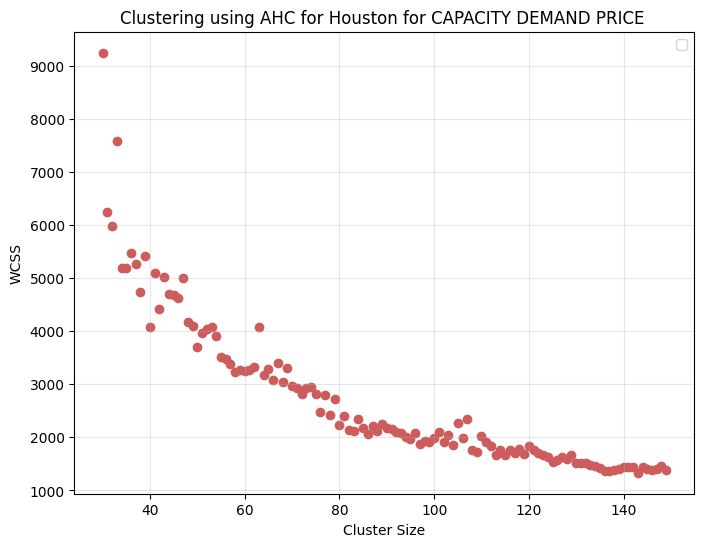

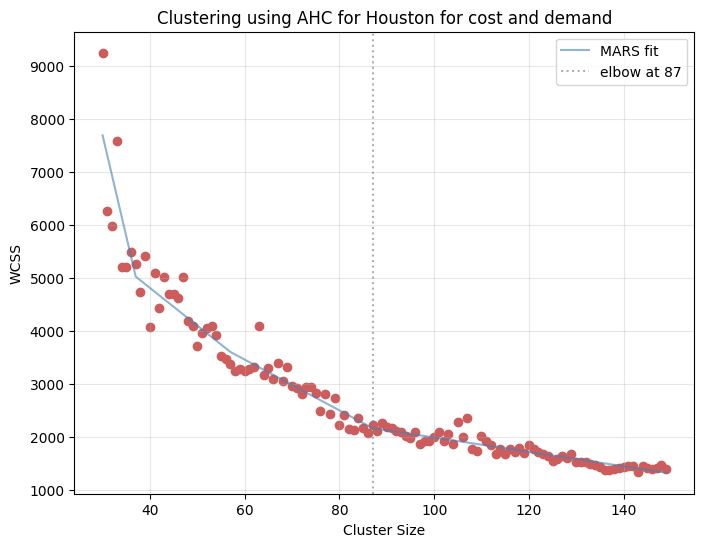

In [16]:
wcss = agg_hierarchial_elbow(scenario= scenario, scale_level=1, include= [IncludeAHC.CAPACITY, IncludeAHC.DEMAND, IncludeAHC.PRICE], range_list = range_list)
elbow = mars_elbow(wcss, range_list)
# elbow = 62


In [17]:
scenario_reduced, repday_reduced, info_reduced =  reduce_scenario(scenario=scenario, periods=elbow, scale_level=1, method=Clustermethod.AHC, include = [IncludeAHC.CAPACITY, IncludeAHC.DEMAND, IncludeAHC.PRICE])
milp_reduced = formulate(scenario= scenario_reduced, \
        constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, \
        objective=Objective.COST, write_lpfile = True)
results_reduced = solve(scenario = scenario_reduced, instance= milp_reduced, solver= 'gurobi', name=f"reduced_res", print_solversteps = True)

constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport imp cost
constraint transport cost
constraint transport cost network
constraint demand
objective cost
Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 301012 rows, 2

In [18]:
# def resulter(elbow):
#     scenario_reduced, repday_reduced, info_reduced =  reduce_scenario(scenario=scenario, periods=elbow, scale_level=1, method=Clustermethod.agg_hierarchial, include = [IncludeAHC.capacity, IncludeAHC.demand, IncludeAHC.cost])
#     milp_reduced = formulate(scenario= scenario_reduced, demand = {newyork: {Power: 80}, houston: {Power: 0}, sandiego: {Power: 0}}, \
#             constraints={Constraints.cost, Constraints.inventory, Constraints.production, Constraints.resource_balance, Constraints.transport, Constraints.mode}, \
#             objective=Objective.cost)
#     results_reduced = solve(scenario = scenario_reduced, instance= milp_reduced, solver= 'gurobi', name=f"reduced_res", print_solversteps = True)
#     return results_reduced

# results = {i: resulter(30 + i*10) for i in range(6)}

**Reduced Case Study**

In [19]:
# o = 2.526191289141e+09
# opts = [results[i].output['objective'] for i in range(6)]
# error = [(o - results[i].output['objective'])*100/o for i in range(6)]
# clusters = [30 + i*10 for i in range(6)]

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
# fig, ax = plt.subplots(figsize = (9,6))
# ax.stem([30 + i*10 for i in range(6)], error)
# plt.xlabel('cluster size')
# plt.ylabel(f"% solution error")
# plt.title(f"Influnce of cluster size on solution accuracy")
# plt.rcdefaults()



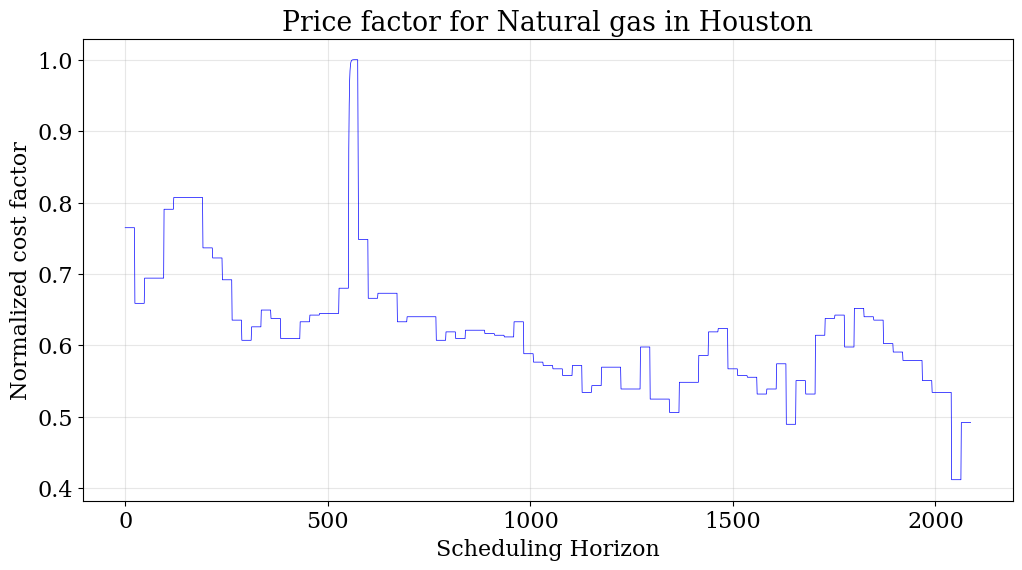

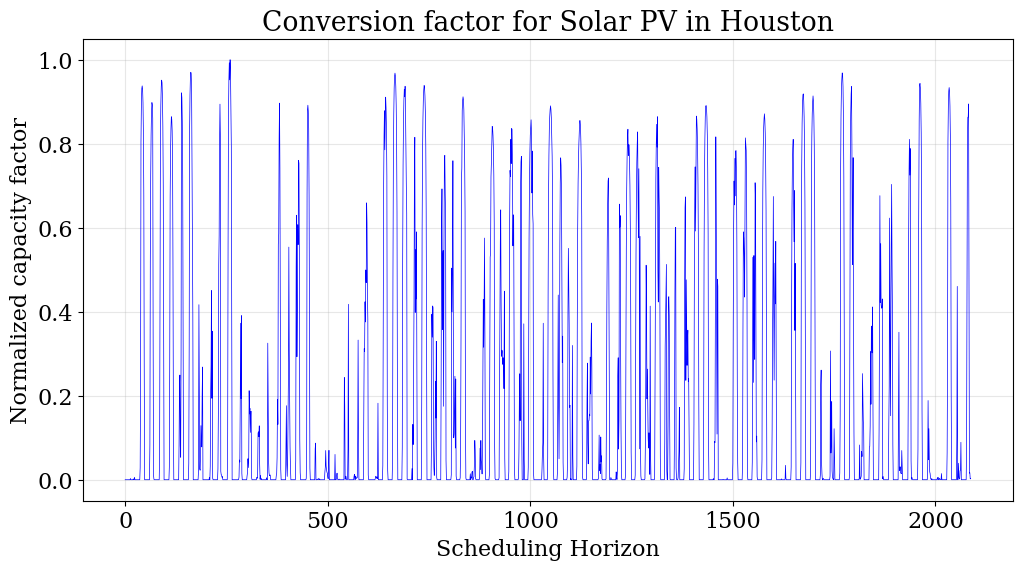

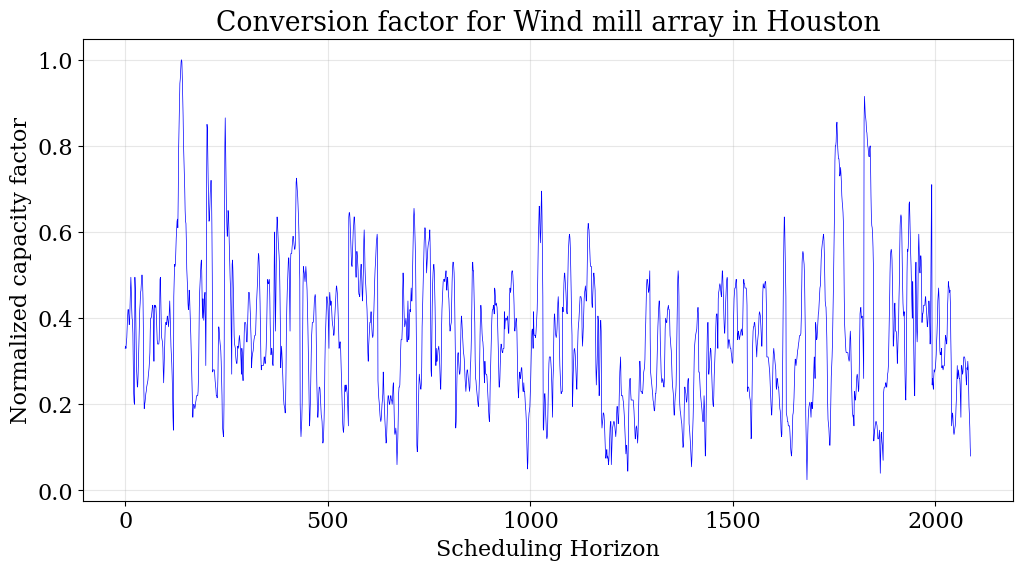

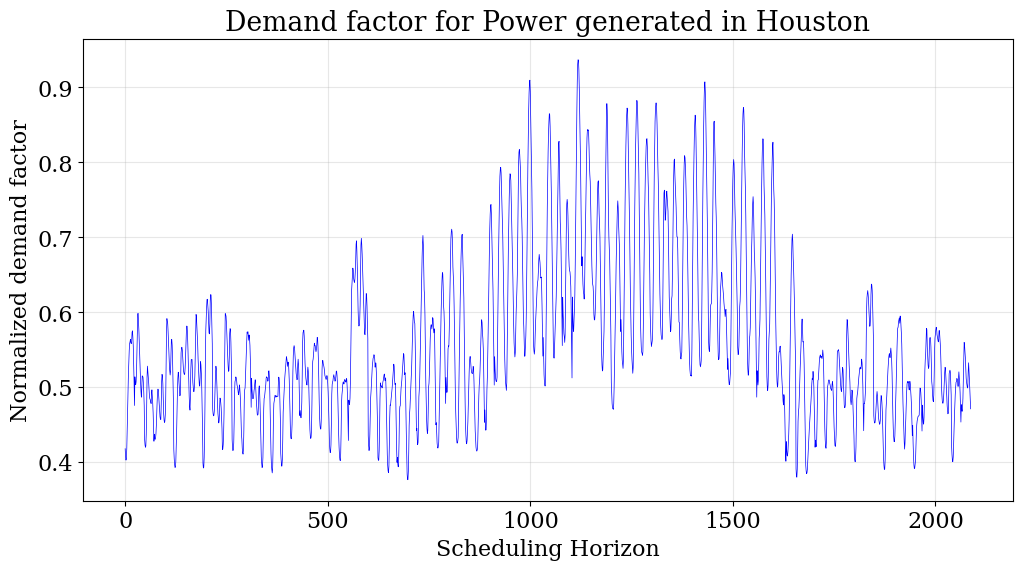

In [20]:
plot_scenario.price_factor(scenario= scenario_reduced, location= houston, resource= CH4)
plot_scenario.capacity_factor(scenario= scenario_reduced, location= houston, process= PV)
plot_scenario.capacity_factor(scenario= scenario_reduced, location= houston,process= WF)
plot_scenario.demand_factor(scenario= scenario_reduced, location= houston, resource= Power)


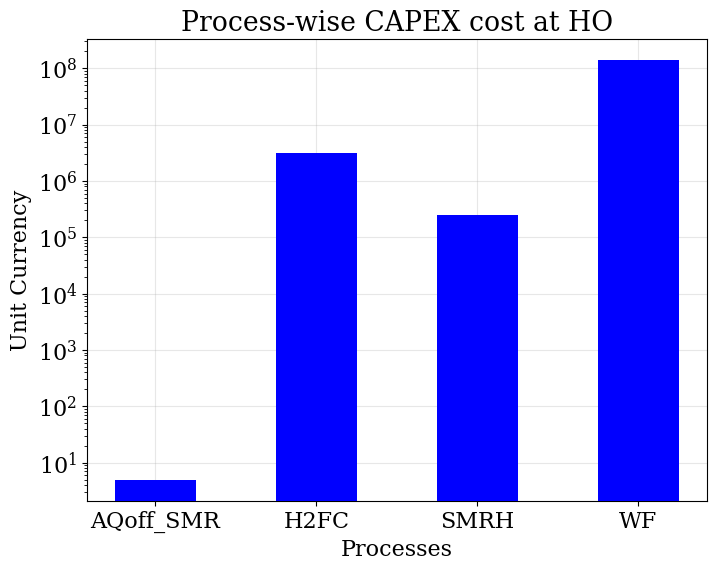

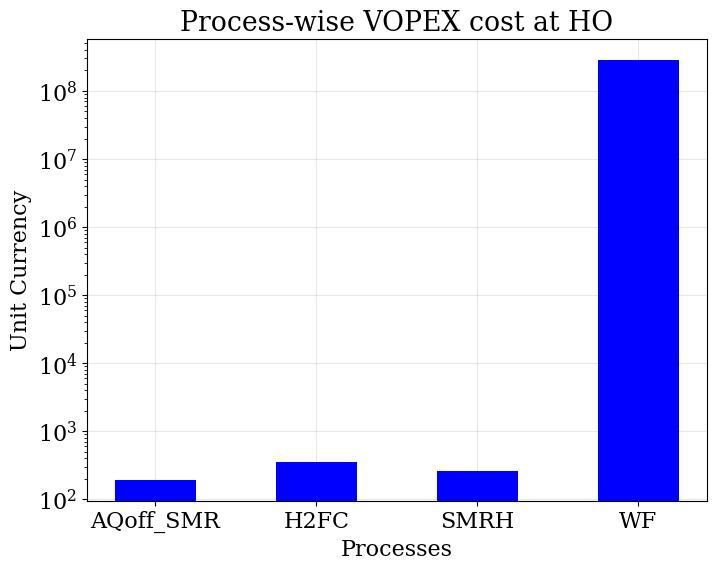

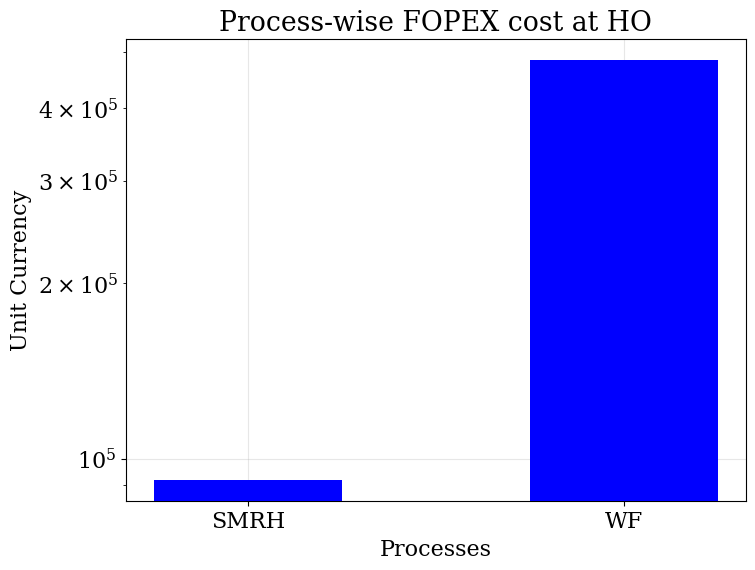

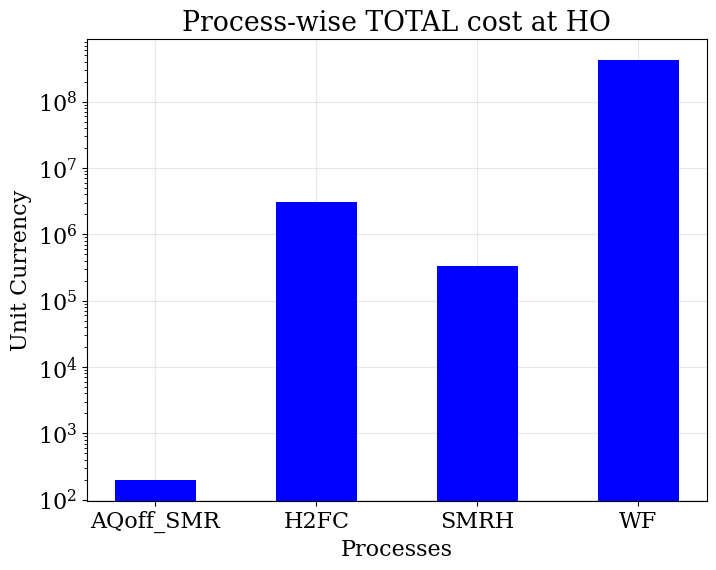

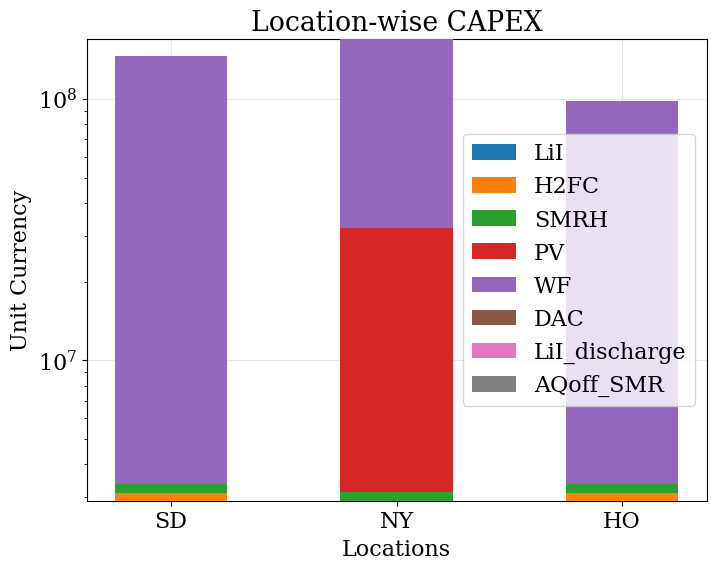

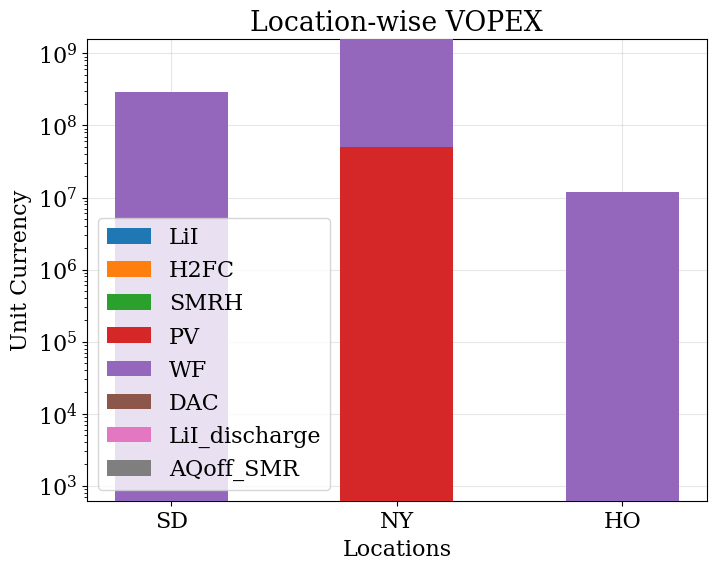

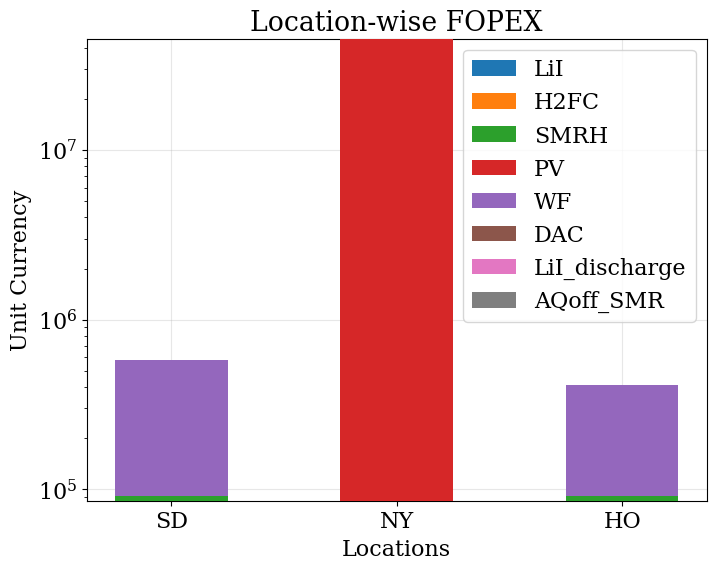

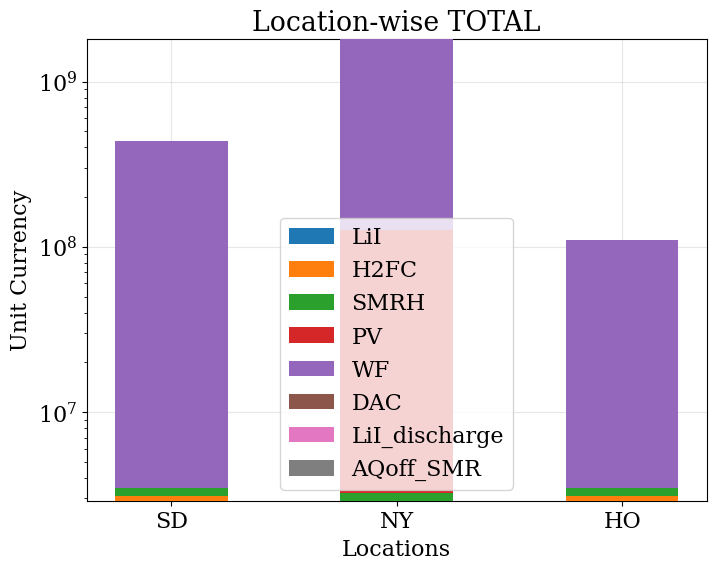

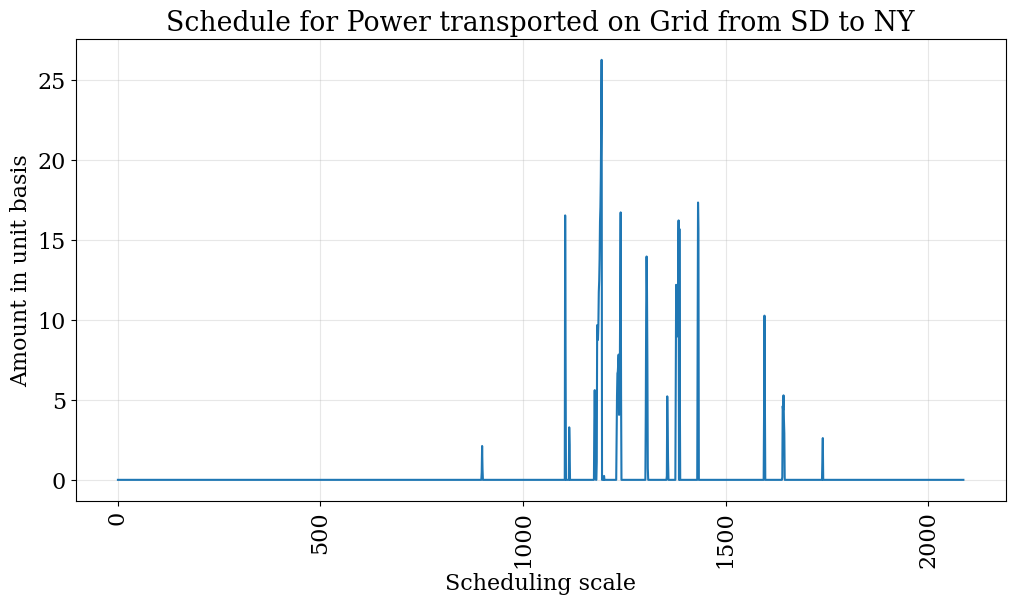

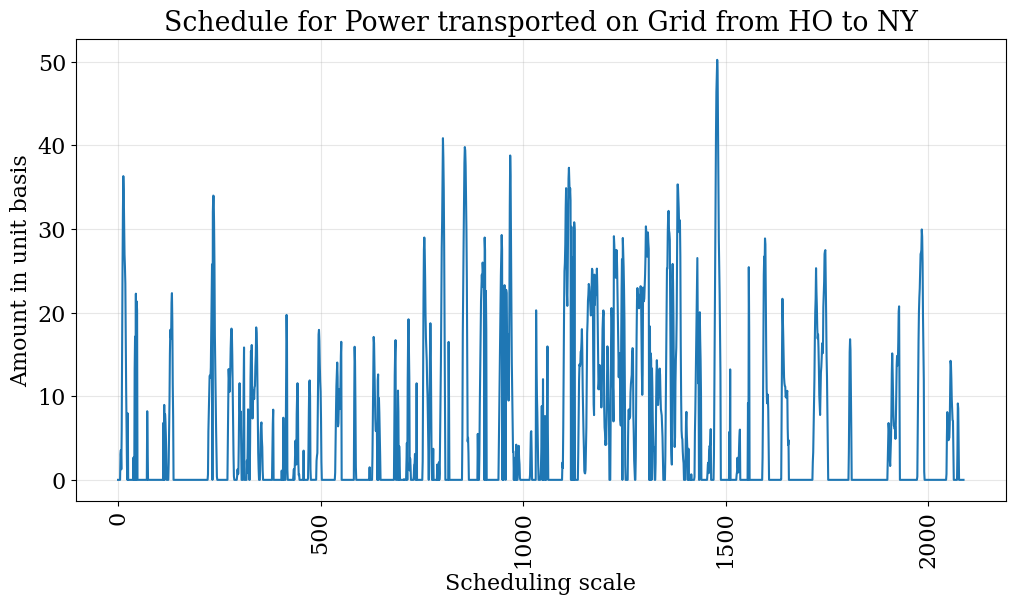

In [21]:
plot_results.cost(results= results_reduced, x = CostX.PROCESS_WISE, y = CostY.CAPEX, location= 'HO', fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.PROCESS_WISE, y = CostY.VOPEX, location= 'HO', fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.PROCESS_WISE, y = CostY.FOPEX, location= 'HO', fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.PROCESS_WISE, y = CostY.TOTAL, location= 'HO', fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.LOCATION_WISE, y = CostY.CAPEX, fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.LOCATION_WISE, y = CostY.VOPEX, fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.LOCATION_WISE, y = CostY.FOPEX, fig_size= (8,6))
plot_results.cost(results= results_reduced, x = CostX.LOCATION_WISE, y = CostY.TOTAL, fig_size= (8,6))
plot_results.transport(results= results_reduced, source= 'SD', sink = 'NY', resource= 'Power', transport = 'Grid')
plot_results.transport(results= results_reduced, source= 'HO', sink = 'NY', resource= 'Power', transport = 'Grid')

In [22]:
x = list(scenario_reduced.capacity_factor['HO']['PV'].values())
x.count(0)/len(x)
    

0.5220306513409961